# Project 3 Data Cleaning & EDA

## Contents:

- **[Import Libraries](#Import-Libraries)**.  
    
- **[Data Cleaning & EDA](#Data-Cleaning-Exploratory-Data-Analysis)**.  

- **[Model Preparation](#Model-Preparation)**. 

 - **[Modeling](#Modeling)**.  
   - **[Baseline Model](#Baseline-Model)**. 
   - **[Pipeline Models](#Pipeline-Models)**. 
   - **[Logistic Regression Models](#Logistic-Regression-Models)**. 
   - **[Naive Bayes Models](#Naive-Bayes-Models)**.  
   - **[Random Forest](#Random-Forest)**.  
   - **[Extra Trees](#Extra-Trees)**.  
   - **[Bagging Classifier](#Baggin-Classifier)**.  
   - **[DecisionTreeClassifier](#DecisionTreeClassifier)**.  
   
   
- **[Model Evaluation](#Model-Evaluation)**.  

- **[Conclusions and Recommendations](#Conclusions-and-Recommendations)**.  

- **[References](#References)**.

### Import Libraries

In [421]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text


from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import time
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, ImageColorGenerator


import matplotlib.pyplot as plt
%matplotlib inline

#### Reading csv files

In [114]:
baby_data = pd.read_csv('../data/result1.csv')

In [115]:
baby_data.shape

(1724, 32)

In [116]:
Pets_data = pd.read_csv('../data/result2.csv')

In [117]:
Pets_data.shape

(2959, 32)

Frequency of classes are similar in both data. There is no need to stratify or correct for imbalanced data

In [118]:
comb_data = pd.read_csv('../data/combined_db.csv') 

### Data cleaning & EDA

In [119]:
comb_data.head()

,subreddit,subreddit_type,author,created_utc,link_flair_text_color,link_flair_type,retrieved_on,score,subreddit_subscribers,subreddit_type.1,...,is_robot_indexable,is_self,is_video,locked,media_only,over_18,pinned,spoiler,stickied,timestamp
0,baby,public,purehoopla,1584915670,dark,text,1584915676,1,6852,public,...,False,True,False,False,False,False,False,False,False,2020-03-22
1,baby,public,Renegade626,1584933321,dark,text,1584933322,1,6855,public,...,True,True,False,False,False,False,False,False,False,2020-03-22
2,baby,public,mytrendybabystore,1584983015,dark,text,1584983020,1,6856,public,...,False,True,False,False,False,False,False,False,False,2020-03-23
3,baby,public,mytrendybabystore,1584988382,dark,text,1584988392,1,6857,public,...,False,True,False,False,False,False,False,False,False,2020-03-23
4,baby,public,kellimoxie,1585016982,dark,text,1585016988,1,6860,public,...,True,True,False,False,False,False,False,False,False,2020-03-23


checking null value

In [121]:
comb_data.isnull().sum().sum()

0

There is no null values.

In [123]:
comb_data.dtypes

subreddit                 object
subreddit_type            object
author                    object
created_utc                int64
link_flair_text_color     object
link_flair_type           object
retrieved_on               int64
score                      int64
subreddit_subscribers      int64
subreddit_type.1          object
title                     object
domain                    object
full_link                 object
url                       object
is_reddit_media_domain      bool
no_follow                   bool
send_replies                bool
can_mod_post                bool
contest_mode                bool
is_crosspostable            bool
is_meta                     bool
is_original_content         bool
is_robot_indexable          bool
is_self                     bool
is_video                    bool
locked                      bool
media_only                  bool
over_18                     bool
pinned                      bool
spoiler                     bool
stickied  

In [124]:
comb_data['subreddit'].value_counts()

Pets    2959
baby    1724
Name: subreddit, dtype: int64

Create Binary y column based on subreddit name

In [125]:
comb_data['y'] = comb_data['subreddit'].map(lambda x: 1 if x == 'baby' else 0)

comb_data.head(2)

,subreddit,subreddit_type,author,created_utc,link_flair_text_color,link_flair_type,retrieved_on,score,subreddit_subscribers,subreddit_type.1,...,is_self,is_video,locked,media_only,over_18,pinned,spoiler,stickied,timestamp,y
0,baby,public,purehoopla,1584915670,dark,text,1584915676,1,6852,public,...,True,False,False,False,False,False,False,False,2020-03-22,1
1,baby,public,Renegade626,1584933321,dark,text,1584933322,1,6855,public,...,True,False,False,False,False,False,False,False,2020-03-22,1


In [126]:
comb_data['y'].value_counts(normalize=True)

0    0.63186
1    0.36814
Name: y, dtype: float64

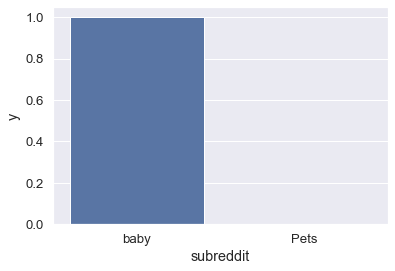

In [306]:
sns.barplot(x = comb_data['subreddit'], y = comb_data['y']);

In [127]:
comb_data['title']

0          What It’s Like to Be (Very) Pregnant Right Now
1                       Tummy sleeper wakes several times
2        Online Resources For Kids During Home Quarantine
3               Chicken Pot Pie The Whole Family Can Make
4       I could use advice regarding a cancelled baby ...
                              ...                        
4678                            Cat begs for food nonstop
4679     Found a price sticker in Royal Canin Small Adult
4680    6 month old kitty sometimes plays with mouth o...
4681                     Remember to keep pets safe today
4682                       Getting pee smell out of couch
Name: title, Length: 4683, dtype: object

Let create a function to tokenize,Lemmatizing & Stemming data

In [128]:
def clean_text(text_to_clean):
    # subs charact in the brackets
    text_to_clean = re.sub( '[^a-zA-Z0-9]', ' ', text_to_clean)
    # subs tabs,newlines and "whitespace-like"
    text_to_clean = re.sub( '\s+', ' ', text_to_clean).strip()
    # convert to lowercase split indv words
    words = text_to_clean.lower().split() 
    #converting stop words to set
    stops = set(stopwords.words('english')) 
    # removing stop words
    meaningful_words = [w for w in words if not w in stops] 
    #Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [129]:
comb_data['clean_title'] = comb_data.apply(lambda x: clean_text(x['title']), axis=1)

In [130]:
comb_data['clean_url']=comb_data.apply(lambda x: clean_text(x['url']), axis=1)

In [131]:
comb_data['clean_full_link']=comb_data.apply(lambda x: clean_text(x['full_link']), axis=1)

In [311]:
comb_data.head(2)

,subreddit,subreddit_type,author,created_utc,link_flair_text_color,link_flair_type,retrieved_on,score,subreddit_subscribers,subreddit_type.1,...,media_only,over_18,pinned,spoiler,stickied,timestamp,y,clean_title,clean_url,clean_full_link
0,baby,public,purehoopla,1584915670,dark,text,1584915676,1,6852,public,...,False,False,False,False,False,2020-03-22,1,like pregnant right,https www reddit com r baby comments fn8hsd li...,https www reddit com r baby comments fn8hsd li...
1,baby,public,Renegade626,1584933321,dark,text,1584933322,1,6855,public,...,False,False,False,False,False,2020-03-22,1,tummy sleeper wakes several times,https www reddit com r baby comments fncyve tu...,https www reddit com r baby comments fncyve tu...


### Model Preparation 

establish X and Y

In [343]:
X = comb_data['clean_title']
y = comb_data['y']

Split data into training and testing sets

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [197]:
cv = CountVectorizer()
tvect = TfidfVectorizer()

#### Stopwords

Let's look at sklearn's stopwords.

In [198]:
#print(CountVectorizer(stop_words = 'english').get_stop_words())

In [199]:
STOP_WORD = ['eg', 'un', 'am', 'ltd', 'etc', 'may', 'my', 'thru', 'for',
                                'from', 'inc', 'con', 'more', 'ie', ]

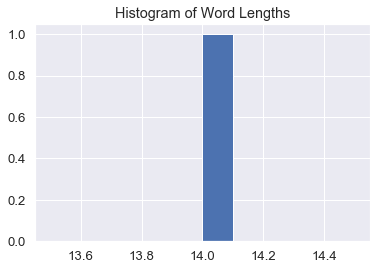

In [298]:
# Plot the lengths of the words.
plt.hist(len(STOP_WORD))
plt.title('Histogram of Word Lengths');

Thus length of our stopwords are between 14.0 to 14.2.

In [214]:
cv = CountVectorizer(stop_words= STOP_WORD)
tvect = TfidfVectorizer(stop_words = STOP_WORD)

In [316]:
# grabbing just for titles
X_t = comb_data['title']

In [318]:
# count vectorizing and put in dataframe
X_t = cv.fit_transform(X_t)
X_t_df = pd.DataFrame(X_t.toarray(), columns = cv.get_feature_names())

In [319]:
picked_words = X_t_df.sum().sort_values(ascending=False)[:30]

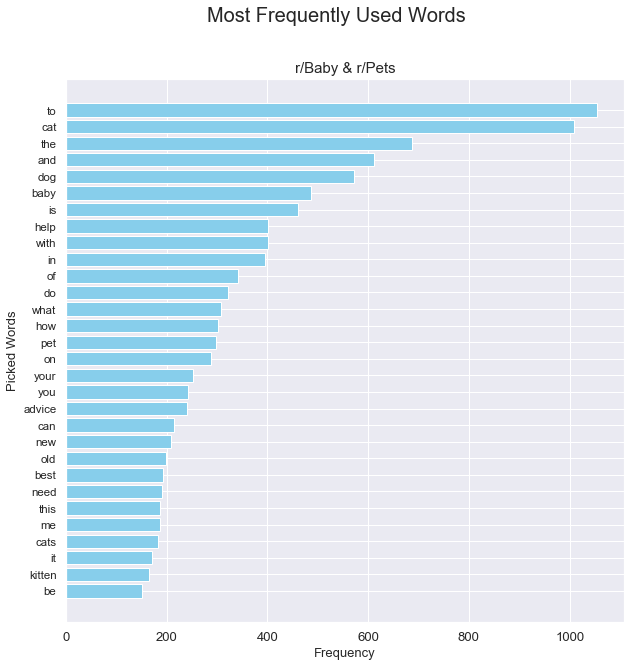

In [324]:
plt.figure(figsize=(10,10))
plt.barh(y=picked_words.index[::-1],width=picked_words[::-1],color='skyblue')
plt.suptitle('Most Frequently Used Words',size=20)
plt.title('r/Baby & r/Pets',size=15)
plt.xlabel('Frequency',size=13)
plt.ylabel('Picked Words',size=13)
plt.yticks(size=11.5);

These are most frequently used words found in both subreddits. Most of these words are general words that do not give us much meaning like to, be, it. Some of them make sense given that our two subreddits are focused on Popularities. Possibly important words that could help determine which subreddit a post is from cat, dog, baby,need, kitten.

### Modeling

#### Baseline Model

Since this is a classification problem (and we'll be using accuracy as our metric), the baseline model is to predicted the most frequently occuring target class.The baseline accuracy is the percentage of the majority class, regardless of whether it is 1 or 0. It serves as the benchmark for our model to beat.

In [140]:
y.value_counts(normalize=True)

0    0.63186
1    0.36814
Name: y, dtype: float64

Here 1 as 'baby' and 0 as 'Pets' expect an accuracy of ~36% and ~63%. Any model performing well above this will be a significant improvement to the baseline model.

In [174]:
# instantiate DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

# score on test
print('Test Score:', dummy.score(X_test, y_test))

# score on train
print('Train Score:', dummy.score(X_train, y_train))

# score on cross val
print('Cross Val Score:', cross_val_score(dummy, X, y, cv =5).mean())

Test Score: 0.6319385140905209
Train Score: 0.6318337129840547
Cross Val Score: 0.6318599549389303


Our baseline model is at ~63% accuracy.
Therefore, we are looking to build a model that does better than 63%, otherwise our best bet is to blindly guess the same outcome every time.

#### Pipeline Models

 Instantiate GridSearchCV & Fit GridSearch to training data.

#### Logistic Regression Models

In [216]:
lr = LogisticRegression()

cv_lr_pipe = Pipeline([
    ('cv', cv), #transformer
    ('lr', lr)  # estimator
])

params_1 = {
    'lr__penalty' : ['l2', 'l1'],
    'lr__C' : [1, 2, .5],
    'cv__max_features':[None,5_000,10_000],
    'cv__min_df': [2, 3],
    'cv__max_df': [.9, .95],
    'cv__ngram_range':[(1,1),(1,2)] }

gs_cv = GridSearchCV(cv_lr_pipe, 
                  params_1,
                  cv = 5)
gs_cv.fit(X_train, y_train)
print('Train Score:', gs_cv.score(X_train, y_train))
print('Test Score:', gs_cv.score(X_test, y_test))
print('Cross Val Score:', cross_val_score(gs_cv.best_estimator_,X,y,cv=5).mean())
print('Best parameters:', gs_cv.best_params_)


Train Score: 0.9877562642369021
Test Score: 0.9376601195559351
Cross Val Score: 0.9511034945133131
Best parameters: {'cv__max_df': 0.9, 'cv__max_features': None, 'cv__min_df': 2, 'cv__ngram_range': (1, 2), 'lr__C': 2, 'lr__penalty': 'l2'}


In [395]:
tfidf_lr_pipe = Pipeline([
    ('tvect', tvect), #transformer
    ('lr', lr)        # estimator
])

params_2 = {
    'lr__penalty' : ['l2', 'l1'],
    'lr__C' : [1, 2, .5],
    'tvect__max_features':[None,4_000,5_000,10_000],
    'tvect__min_df': [2, 3],
    'tvect__max_df': [.9, .95],
    'tvect__ngram_range':[(1,1),(1,2)]
}

gs_tfidf = GridSearchCV(tfidf_lr_pipe, 
                  params_2,
                  cv = 5)
gs_tfidf.fit(X_train, y_train)

print('Train Score:', gs_tfidf.score(X_train, y_train))
print('Test Score:', gs_tfidf.score(X_test, y_test))
print('Cross Val Score:', cross_val_score(gs_tfidf.best_estimator_,X,y,cv=5).mean())
print('Best parameters:', gs_tfidf.best_params_)

Train Score: 0.9834851936218679
Test Score: 0.9444918872758327
Cross Val Score: 0.9500364866960386
Best parameters: {'lr__C': 2, 'lr__penalty': 'l2', 'tvect__max_df': 0.9, 'tvect__max_features': None, 'tvect__min_df': 2, 'tvect__ngram_range': (1, 2)}


#### Naive Bayes Models

Multinomial NB

In [225]:
mnb = MultinomialNB()

m_nb_pipe = Pipeline([
    ('cv', cv),    #transformer
    ('mnb', mnb)   # estimator
])

params_1 = {
    'mnb__alpha' : [1.0, .5],
    'mnb__class_prior' : [None, 5],
    'cv__max_features':[None,5_000,10_000],
    'cv__min_df': [2, 3, 4],
    'cv__max_df': [.9, .95, .85],
    'cv__ngram_range':[(1,1),(1,2)]
}
    
gs_m_nb = GridSearchCV(m_nb_pipe, 
                  params_1,
                  cv = 5)

gs_m_nb.fit(X_train, y_train)

print('Train Score:', gs_m_nb.score(X_train, y_train))
print('Test Score:', gs_m_nb.score(X_test, y_test))
print('Cross Val Score:', cross_val_score(gs_m_nb.best_estimator_,X,y,cv=5).mean())
print('Best parameters:', gs_m_nb.best_params_)

Train Score: 0.9626993166287016
Test Score: 0.9316823228010248
Cross Val Score: 0.9340204234281076
Best parameters: {'cv__max_df': 0.9, 'cv__max_features': None, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'mnb__alpha': 0.5, 'mnb__class_prior': None}


Binomial NB

In [227]:
bnb = BernoulliNB()

params_2 = {
    'bnb__alpha' : [1.0, .5],
    'bnb__binarize' : [0.0, 0.5],
    'tvect__max_features':[None,4_000,5_000,10_000],
    'tvect__min_df': [2, 3],
    'tvect__max_df': [.9, .95],
    'tvect__ngram_range':[(1,1),(1,2)]
}
gs_b_nb = GridSearchCV(b_nb_pipe, 
                  params_2,
                  cv = 5)

gs_b_nb.fit(X_train, y_train)

print('Train Score:', gs_b_nb.score(X_train, y_train))
print('Test Score:', gs_b_nb.score(X_test, y_test))
print('Cross Val Score:', cross_val_score(gs_b_nb.best_estimator_,X,y,cv=5).mean())
print('Best parameters:', gs_b_nb.best_params_)


Train Score: 0.9604214123006833
Test Score: 0.9274124679760888
Cross Val Score: 0.9301779182515576
Best parameters: {'bnb__alpha': 0.5, 'bnb__binarize': 0.0, 'tvect__max_df': 0.9, 'tvect__max_features': None, 'tvect__min_df': 2, 'tvect__ngram_range': (1, 1)}


#### Random Forest

In [238]:
# an instance of RandomForestClassifier 
rf = RandomForestClassifier(random_state=1050)

rf_params = {
    'n_estimators': [50, 100, 200, 400],
     'max_depth' : [None, 2, 3, 4],
     'max_features': [None, 'auto']
}

gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=5)
# Fiting
gs_rf.fit(X_train_vec,y_train)


#rounded down features in each split for classification problem.
print("Train Score: ", gs_rf.score(X_train_vec,y_train))
print("Test Score: ", gs_rf.score(X_test_vec,y_test))
print("Best Score: ", gs_rf.best_score_)

Train Score:  0.9982915717539863
Test Score:  0.9342442356959864
Best Score:  0.9290942764626975


#### Extra Trees

In [235]:
# an instance of ExtraTreesClassifier
et = ExtraTreesClassifier(random_state=42)

et_params = {
    'n_estimators': [50, 100, 150],
     'max_depth' : [None, 2, 3, 4],
     'max_features': [None, 'auto']
}

gs_et = GridSearchCV(rf, param_grid=et_params, cv=5)
# Fiting
gs_et.fit(X_train_vec,y_train)

#rounded down features in each split for classification problem.
print("Train Score: ", gs_et.score(X_train_vec,y_train))
print("Test Score: ", gs_et.score(X_test_vec,y_test))
print("Best Score: ", gs_et.best_score_)

Train Score:  0.9982915717539863
Test Score:  0.9350982066609735
Best Score:  0.9308028676449729


#### Bagging Classifier

In [279]:
bagged = BaggingClassifier(random_state=42)

bagged_params = {'base_estimator' : [None, 50, 100],
               'n_estimators' : [10, 20],
               'max_samples' : [1, 5, 10],
                 'max_features' : [1.0, 1.5]
}
gs_bagged = GridSearchCV(bagged, param_grid=bagged_params, cv=5)
# Fiting
gs_bagged.fit(X_train_vec,y_train)

#rounded down features in each split for classification problem.
print("Train Score: ", gs_bagged.score(X_train_vec,y_train))
print("Test Score: ", gs_bagged.score(X_test_vec,y_test))
print("Best Score: ", gs_bagged.best_score_)
print('Best parameters:', gs_bagged.best_params_)

Train Score:  0.7201025056947609
Test Score:  0.7250213492741246
Best Score:  0.7070224070224069
Best parameters: {'base_estimator': None, 'max_features': 1.0, 'max_samples': 10, 'n_estimators': 10}


#### DecisionTreeClassifier

In [256]:
dtc = DecisionTreeClassifier(random_state=42)

dtc_params = {'ccp_alpha' : [0.0, 0.5, 1],
               'max_depth' : [None, 1, 5, 10],
                 'max_features' : [None, 100, 200]
}
gs_dtc = GridSearchCV(dtc, param_grid=dtc_params, cv=5)
# Fiting
gs_dtc.fit(X_train_vec,y_train)

#rounded down features in each split for classification problem.
print("Train Score: ", gs_dtc.score(X_train_vec,y_train))
print("Test Score: ", gs_dtc.score(X_test_vec,y_test))
print("Best Score: ", gs_dtc.best_score_)

Train Score:  0.9982915717539863
Test Score:  0.9197267292912041
Best Score:  0.9182757656441867


Using accuracy as metric, evaluate all models on the training and testing sets

| Model                           | Train Score | Test Score |
|---------------------------------|-------------|------------|
| Baseline                        | 0.6318      | 0.6319     |
| CountVectorizer(estimator = lr) | 0.987       | 0.937      |
|**TfidfVectorizer(est=lr)**      | 0.983       | 0.944      |
| MultinomialNB                   | 0.962       | 0.931      |
| BernoulliNB                     | 0.960       | 0.927      |
| Random Forest                   | 0.998       | 0.934      |
| Extra Trees                     | 0.998       | 0.935      |
| Bagging Classifier              | 0.720       | 0.725      |
| DecisionTreeClassifier          | 0.998       | 0.9197     |

From the above table we can see Bagging Classifier has the best train score 0.7201 and test score 0.7250. but the predictive power of the model is much less than the others which have much higher testing scores.So we pick TfidfVectorizer with Estimator logistic regression.here train score is .983 and test score is .944 that means model is with low bias and high variance. So our model is overfitted.

### Model Evaluation


##### Interpreting the coeficients

Lets find coefficients from interpretable model using logistic regression

In [438]:
#help by saiful Hasan
#coefficient calculation
lr = LogisticRegression()
tvect = TfidfVectorizer(max_df =0.9, max_features=None, 
                       min_df=2, ngram_range =(1, 2)
                         )

tfidf_lr_pipe = Pipeline([
    ('tvect', tvect), #transformer
    ('lr', lr)        # estimator
])
tfidf_lr_pipe.fit(X_train, y_train)
print('Train Score:', gs_tfidf.score(X_train, y_train))
print('Test Score:', gs_tfidf.score(X_test, y_test))

lr.coef_;  #coeffcient 
Coefficient_list = pd.DataFrame(data=lr.coef_.T, index=tvect.get_feature_names());  #create daatframe
Coefficient_list.columns = ['coefficient']
Coefficient_list['coefficient'].sort_values(ascending = False)[:20]  #show top 20 features for interpretation

Train Score: 0.9834851936218679
Test Score: 0.9444918872758327


baby          6.582897
giveaway      3.792313
kids          2.628661
babies        2.253493
gifts         2.155783
best          2.136540
gift          2.011872
recipe        1.853338
review        1.775358
sleep         1.688273
formula       1.539733
nyc           1.530229
diapers       1.526030
family        1.492537
best gifts    1.482229
teething      1.458900
bottle        1.437863
pregnant      1.414145
moms          1.403396
newborn       1.402561
Name: coefficient, dtype: float64

In [439]:
Coefficient_list['coefficient'].sort_values()[:20] #random 20

cat       -9.411221
dog       -6.990628
pet       -5.213621
kitten    -4.026287
cats      -3.985058
pets      -3.775175
puppy     -3.147989
dogs      -3.043727
kittens   -2.006485
fleas     -1.790914
hamster   -1.704159
kitty     -1.678763
vet       -1.661599
animal    -1.582264
help      -1.501189
bird      -1.474600
pup       -1.472736
getting   -1.406026
bunny     -1.270637
animals   -1.258153
Name: coefficient, dtype: float64

In [451]:
#baby
np.exp(6.582897) 

722.6297582103326

In [434]:
#kids
np.exp(2.628661)

13.85520535596834

In [440]:
#pet
np.exp(-5.213621)

0.005441932729791709

In [441]:
#kittens
np.exp(2.006485)

7.437129838353084

In [449]:
#dog       
(np.exp(-6.990628) - 1) *100

-99.90795317039675

for every 1 unit increase for 'baby' in the title, that submission was 722.6 times as likely to be bening. Same like for kids, pets and kitten submission was 13.85, .005 and 7.43 times respectively, and else held equally. Also for dog, the submission was 99.9 %  likely to belong to the subreddits, else are held.

Although it SEEMS like this would be the end of the evaluating our model, part of the classification workflow includes digging a little deeper into the models performance regarding model errors.
Much like regression models looks to its residuals for insights, classification also looks at its errors, known as misclassifications, which is typically portrayed as a "confusion matrix".

Using our selected model TfidfVectorizer using Logistic Regression as estimator let us create a function for confusion matrix

In [387]:
def pretty_confusion_matrix(y_true, y_pred):
    
    # handling data
    cm = confusion_matrix(y_true, y_pred)
    labels = y_true.unique()
    labels.sort()
    
    # plotting
    sns.set(font_scale=1.2)
    plt.figure(figsize=(10,4))
    
    sns.heatmap(cm, annot=True, fmt='g', cmap="PiYG",xticklabels=labels, yticklabels=labels, annot_kws={"size": 20})
    plt.title("TfidfVectorizer Model Matrix (1 = r/baby)")
    plt.xlabel('Predicted Subreddit')
    plt.ylabel('True Subreddit')

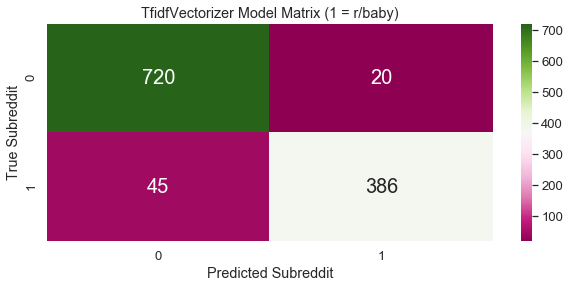

In [388]:
pretty_confusion_matrix(y_test, gs_tfidf.predict(X_test))

In [389]:
#pretty_confusion_matrix(y_test, bagged.predict(X_test_vec))

 Calculate model accuracy from above matrix

In [390]:
accuracy =(386+720)/(386+720+20+45) #prediction are currect
accuracy * 100

94.44918872758326

In [391]:
misclasification_rate = 1 - accuracy #prediction are incorrect
misclasification_rate * 100

5.550811272416734

In [393]:
Specificity = 720/ (720+ 20) #True negative rate
Specificity * 100

97.2972972972973

In [394]:
Sensitivity = 386/ (386+ 45)  # True positive rate
Sensitivity * 100

89.55916473317865

Our model seems to have few false negatives and few false positives, so we have verified our model is actually a strong model.
Thus the proportion of prediction for the subreddits are ~94% Accurate.That is good achievement for us.

### Conclusions and Recommendations

Thus this model will be able to predict a posts for both subreddit with very good accuracy of ~94% by the TfidfVectorizer using Logistic Regression as estimator. In the real world we can find Young Americans may be less likely to be homeowners or parents of human children, but they are leading in their rate of pet ownership. Popularity of baby priority over pets. If we have more data we can be more predictable than this.

This project can be recommended for:
- Use for sentiment analysis of pets vs baby priority
- also how to pull data requests from web

### References

- [Pushshift API](https://github.com/pushshift/api)

- https://api.pushshift.io/reddit/search/submission?subreddit=baby

- https://api.pushshift.io/reddit/search/submission?subreddit=Pets

- https://www.epochconverter.com

- https://pushshift.io/api-parameters/